In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import scipy
from scipy.stats import multivariate_normal
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
class ip:
    #Ip for 'inverse problem'
    # Initialize prior chain starting point,
    # chain burn-in length and total length, and 
    # Q (for proposal samples).  
    # Initialize experimental data.
    #theta = np.array([0.15,5.])
    # theta is initialized as the starting point
    # of the chain.  It is placed at the prior
    # mean.
    mcmc_length = 20000 #50000
    mcmc_burn_in = 4000 # 10000number of samples
    # trimmed off the beginning of the Markov
    # chain
    mu_prior = np.array([1e2,1,10])
    cov_prior = np.array([[10., 0., 0.],
                          [0., 10., 0.],
                          [0., 0., 10.]])
    experiment = 2
    temperature = 298.15
    volume = 1000
    Q_mu = np.array([0,0,0]) # Q samples the next step at any point
    # in the chain.  The next step may be accepted or rejected.  Q_mu
    # is centered (0) around the current theta.
    Q_cov = cov_prior/20 # Take small steps.
    
    #main function to get samples
    def MetropolisHastings(self):
        samples = np.zeros((self.mcmc_length,3)) # np.zeros((self.mcmc_length,3))
        samples[0,:] = self.mu_prior #initialize the chain
        likelihoods_vec = np.zeros((self.mcmc_length,1))
        posteriors_un_normed_vec = np.zeros((self.mcmc_length,1))
        priors_vec = np.zeros((self.mcmc_length,1))
        for i in range(1,self.mcmc_length):
            # print(i)
            proposal_sample = samples[i-1,:] + \
                np.random.multivariate_normal( \
                self.Q_mu,self.Q_cov)
            prior_proposal = self.prior(proposal_sample)
            likelihood_proposal = self.likelihood(proposal_sample)
            prior_current_location = self.prior(samples[i-1,:])
            likelihood_current_location = self.likelihood(samples[i-1,:])
            accept_pro = (likelihood_proposal*prior_proposal)/ \
                (likelihood_current_location*prior_current_location)
            uni_rand = np.random.uniform()
            if uni_rand<accept_pro:
                samples[i,:] = proposal_sample
                posteriors_un_normed_vec[i] = \
                         likelihood_proposal*prior_proposal
                likelihoods_vec[i] = likelihood_proposal
                priors_vec[i] = prior_proposal
            else:
                samples[i,:] = samples[i-1,:]
                posteriors_un_normed_vec[i] = likelihood_current_location* \
                         prior_current_location
                likelihoods_vec[i] = likelihood_current_location
                priors_vec[i] = prior_current_location
            ########################################
        samples = samples[self.mcmc_burn_in:]
        posteriors_un_normed_vec = posteriors_un_normed_vec[self.mcmc_burn_in:]
        likelihoods_vec = likelihoods_vec[self.mcmc_burn_in:]
        priors_vec = priors_vec[self.mcmc_burn_in:]
        #posterior probabilites are transformed to a standard normal (std=1)
        #for obtaining the evidence:
        evidence = np.mean(posteriors_un_normed_vec)*np.sqrt(2*np.pi*np.std(samples)**2)
        posteriors_vec = posteriors_un_normed_vec/evidence
        log_ratios = np.log(posteriors_vec/priors_vec)
        # print('log ratios',log_ratios)
        log_ratios[np.isinf(log_ratios)] = 0
        log_ratios = np.nan_to_num(log_ratios)
        info_gain = np.mean(log_ratios)
        return [evidence, info_gain, samples]
    
    def prior(self,sample):
    
        probability = multivariate_normal.pdf(x=sample,
                         mean=self.mu_prior, 
                         cov=self.cov_prior)
        #print('prior: ' + str(probability))
        return probability
        
    def likelihood(self,sample):
        #Replacing k_m with k_B
        sol = odeint(cmr, F0, np.linspace(0,self.volume,2), args=(sample[0], sample[1], sample[2], self.temperature))
        conc_sol_last=sol[-1,:].T 
        #Taking the first sample[0] for getting F_A conc_sol_last[0]
        probability_ra = multivariate_normal.pdf(x=conc_sol_last[0],mean=self.experiment, cov=0.01)
        
        return probability_ra



In [2]:
k_B = 8.61733035e-5
k_1 = 1e2
k_minus_1 = 1
k_m = 10
F0 = np.array([5, 0])
temperatures = np.linspace(298.15,698.15,5)
volumes = np.linspace(100,1100,5)

def cmr(theta,V,k_1,k_minus_1,k_B,T0):
        F_A, F_B = theta
        F_T = F_A + F_B
        P0 = 1
        R = 82.057338
        C_T0 = P0 / (R * T0)
        C_A = C_T0 * F_A / F_T
        C_B = C_T0 * F_B / F_T
        r_A = k_1*C_A - k_minus_1*C_B
        R_B = k_B*C_B
        dFdV = [-r_A, r_A - R_B]
        return dFdV

In [21]:
#steepest ascent
steep_info_gains=[]
steep_t=[]
steep_v=[]
ip_object = ip()
t = 450
v = 700
steep_t.append(t)
steep_v.append(v)
sol = odeint(cmr, F0, np.linspace(0,v,50), args=(1.1*k_1,1.1*k_minus_1,1.1*k_m,t))
conc_sol_last=sol[-1,0].T
ip_object.experiment = conc_sol_last
ip_object.temperature = t
ip_object.volume = v
[evidence, info_gain, samples] = ip_object.MetropolisHastings()
print('Temperature (in K): ',t)
print('Volume (in cc): ',v)
print('Info gain: ', info_gain)
steep_info_gains.append(info_gain)
v = 900
steep_t.append(t)
steep_v.append(v)
ip_object.volume = v
sol = odeint(cmr, F0, np.linspace(0,v,50), args=(1.1*k_1,1.1*k_minus_1,1.1*k_m,t))
ip_object.experiment = conc_sol_last
[evidence, info_gain, samples] = ip_object.MetropolisHastings()
print('Temperature (in K): ',t)
print('Volume (in cc): ',v)
print('Info gain: ', info_gain)
steep_info_gains.append(info_gain)
t=400


for ind in range(2,6):
    print('Temperature (in K): ',t)
    print('Volume (in cc): ',v)
    sol = odeint(cmr, F0, np.linspace(0,v,50), args=(1.1*k_1,1.1*k_minus_1,1.1*k_m,t))
    conc_sol_last=sol[-1,0].T
    ip_object.experiment = conc_sol_last
    ip_object.temperature = t
    ip_object.volume = v
    [evidence, info_gain, samples] = ip_object.MetropolisHastings()
    steep_t.append(t)
    steep_v.append(v)
    steep_info_gains.append(info_gain)
    print('Info gain: ', info_gain)
    if ind % 2 == 0:
        v = 0.2*(steep_v[ind-1]-steep_v[ind-2])/(0.1+steep_info_gains[ind-1]-steep_info_gains[ind-2])+v
    if ind % 2 == 1:
        print("Temperature step")
        print(steep_t[ind-1]-steep_t[ind-2])
        t = 0.2*(steep_t[ind-1]-steep_t[ind-2])/(0.1+steep_info_gains[ind-1]-steep_info_gains[ind-2])+t
        

Temperature (in K):  450
Volume (in cc):  700
Info gain:  2.476645071403419
Temperature (in K):  450
Volume (in cc):  900
Info gain:  2.9638796603224464
Temperature (in K):  400
Volume (in cc):  900
Info gain:  2.4867870033185753
Temperature (in K):  400
Volume (in cc):  968.1158786535913
Info gain:  2.563980898971971
Temperature step
-50
Temperature (in K):  426.5186813221275
Volume (in cc):  968.1158786535913
Info gain:  2.5742648909872767
Temperature (in K):  426.5186813221275
Volume (in cc):  1044.9987513986332
Info gain:  2.6316116036889543
Temperature step
26.51868132212752


In [11]:
evidences=[]
info_gains=[]
all_samples=[]

ip_object = ip()
for v in volumes:
    for t in temperatures:
        print('Temperature (in K): ',t)
        print('Volume (in cc): ',v)
        sol = odeint(cmr, F0, np.linspace(0,v,50), args=(1.1*k_1,1.1*k_minus_1,1.1*k_m,t))
        conc_sol_last=sol[-1,0].T
        ip_object.experiment = conc_sol_last
        ip_object.temperature = t
        ip_object.volume = v
        [evidence, info_gain, samples] = ip_object.MetropolisHastings()
        evidences.append(evidence)
        info_gains.append(info_gain)
        all_samples.append(samples)
        print('Evidence: ' + str(evidence))
        print('Information Gain: ' + str(info_gain))

Temperature (in K):  298.15
Volume (in cc):  100.0
Evidence: 0.3038495410388712
Information Gain: 2.499758012019883
Temperature (in K):  398.15
Volume (in cc):  100.0
Evidence: 0.3061619226633691
Information Gain: 2.5226900037070408
Temperature (in K):  498.15
Volume (in cc):  100.0
Evidence: 0.3131056726453617
Information Gain: 2.5162152916379847
Temperature (in K):  598.15
Volume (in cc):  100.0
Evidence: 0.30940734804263786
Information Gain: 2.536526939762933
Temperature (in K):  698.15
Volume (in cc):  100.0
Evidence: 0.31234817638251844
Information Gain: 2.5316022482475775
Temperature (in K):  298.15
Volume (in cc):  350.0
Evidence: 0.2007989773862609
Information Gain: 2.4923030284699412
Temperature (in K):  398.15
Volume (in cc):  350.0
Evidence: 0.2315512258395044
Information Gain: 2.5040508654795937
Temperature (in K):  498.15
Volume (in cc):  350.0
Evidence: 0.24671944741833088
Information Gain: 2.519253609555093
Temperature (in K):  598.15
Volume (in cc):  350.0
Evidence: 0.2

In [12]:
flow_rates_a=[]
for v in volumes:
    for t in temperatures:
        print('Temperature (in K): ',t)
        print('Volume (in cc): ',v)
        sol = odeint(cmr, F0, np.linspace(0,v,50), args=(1.1*k_1,1.1*k_minus_1,1.1*k_m,t))
        conc_sol_last=sol[-1,0].T
        print('Flow rate:',conc_sol_last)
        flow_rates_a.append(conc_sol_last)

Temperature (in K):  298.15
Volume (in cc):  100.0
Flow rate: 4.570143941335354
Temperature (in K):  398.15
Volume (in cc):  100.0
Flow rate: 4.674481814353496
Temperature (in K):  498.15
Volume (in cc):  100.0
Flow rate: 4.738070087582812
Temperature (in K):  598.15
Volume (in cc):  100.0
Flow rate: 4.780878005254989
Temperature (in K):  698.15
Volume (in cc):  100.0
Flow rate: 4.811660326272232
Temperature (in K):  298.15
Volume (in cc):  350.0
Flow rate: 3.650175167663932
Temperature (in K):  398.15
Volume (in cc):  350.0
Flow rate: 3.950528815749594
Temperature (in K):  498.15
Volume (in cc):  350.0
Flow rate: 4.141877934805913
Temperature (in K):  598.15
Volume (in cc):  350.0
Flow rate: 4.274327898502985
Temperature (in K):  698.15
Volume (in cc):  350.0
Flow rate: 4.371407952887827
Temperature (in K):  298.15
Volume (in cc):  600.0
Flow rate: 2.9134608958824817
Temperature (in K):  398.15
Volume (in cc):  600.0
Flow rate: 3.3379171715014126
Temperature (in K):  498.15
Volume (in

<IPython.core.display.Javascript object>


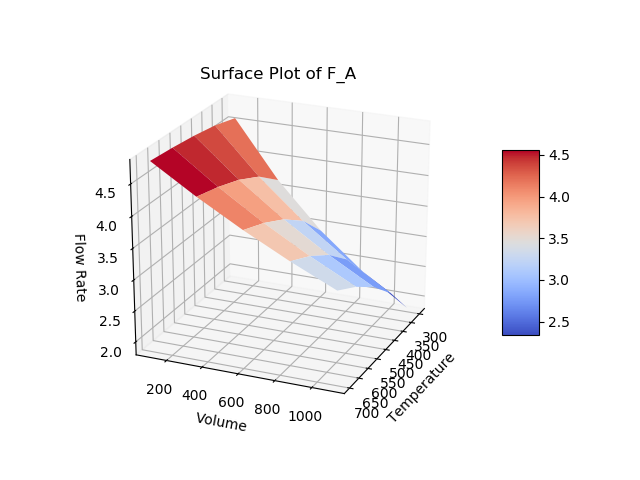

In [13]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T, V = np.meshgrid(temperatures, volumes)
flow_rates_a=np.asarray(flow_rates_a)
FRA = flow_rates_a.reshape(T.shape)
surf = ax.plot_surface(T,V,FRA,cmap=matplotlib.cm.coolwarm)

ax.set_xlabel('Temperature')
ax.set_ylabel('Volume')
ax.set_zlabel('Flow Rate')
ax.set_title('Surface Plot of F_A')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [7]:
flow_rates_b=[]
for v in volumes:
    for t in temperatures:
        print('Temperature (in K): ',t)
        print('Volume (in cc): ',v)
        sol = odeint(cmr, F0, np.linspace(0,v,100), args=(1.1*k_1,1.1*k_minus_1,1.1*k_m,t))
        conc_sol_last=sol[-1,1].T
        print('Flow rate:',conc_sol_last)
        flow_rates_b.append(conc_sol_last)

Temperature (in K):  298.15
Volume (in cc):  100.0
Flow rate: 0.4278997488840998
Temperature (in K):  398.15
Volume (in cc):  100.0
Flow rate: 0.3244121922308769
Temperature (in K):  498.15
Volume (in cc):  100.0
Flow rate: 0.26121992445153086
Temperature (in K):  598.15
Volume (in cc):  100.0
Flow rate: 0.2186279547731028
Temperature (in K):  698.15
Volume (in cc):  100.0
Flow rate: 0.18797617930625862
Temperature (in K):  298.15
Volume (in cc):  350.0
Flow rate: 1.3276638005915748
Temperature (in K):  398.15
Volume (in cc):  350.0
Flow rate: 1.0367049201515086
Temperature (in K):  498.15
Volume (in cc):  350.0
Flow rate: 0.8498318638028726
Temperature (in K):  598.15
Volume (in cc):  350.0
Flow rate: 0.7198582382527484
Temperature (in K):  698.15
Volume (in cc):  350.0
Flow rate: 0.6242903403460734
Temperature (in K):  298.15
Volume (in cc):  600.0
Flow rate: 2.02602932613798
Temperature (in K):  398.15
Volume (in cc):  600.0
Flow rate: 1.6266323955404278
Temperature (in K):  498.15


<IPython.core.display.Javascript object>


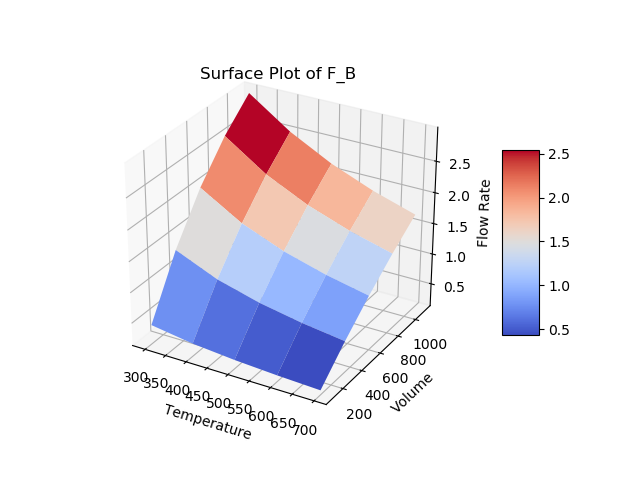

In [8]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T, V = np.meshgrid(temperatures, volumes)
flow_rates_b=np.asarray(flow_rates_b)
FRB = flow_rates_b.reshape(T.shape)
surf = ax.plot_surface(T,V,FRB,cmap=matplotlib.cm.coolwarm)

ax.set_xlabel('Temperature')
ax.set_ylabel('Volume')
ax.set_zlabel('Flow Rate')
ax.set_title('Surface Plot of F_B')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [9]:
import pickle

#Save data
with open('membrane_reactor.pickle','wb') as outfile:
    pickle.dump((evidences,info_gains,all_samples),outfile)

In [7]:
import pickle
# Load data
evidences,info_gains,all_samples = pickle.load(open('membrane_reactor.pickle','rb'))

<IPython.core.display.Javascript object>


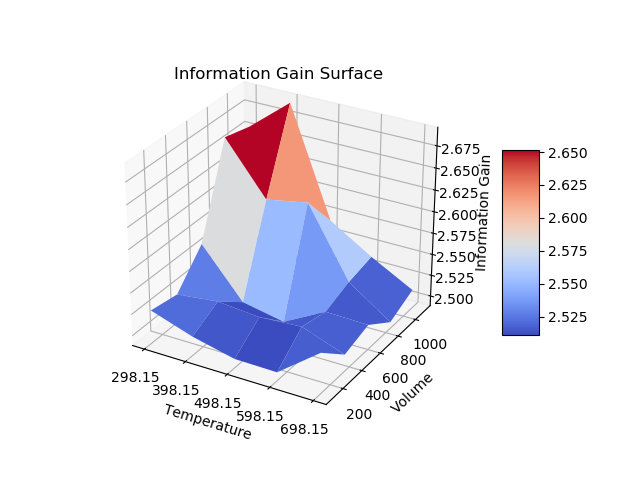

In [8]:
from matplotlib.ticker import FormatStrFormatter
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T, V = np.meshgrid(temperatures, volumes)
info_gains=np.asarray(info_gains)
IG = info_gains.reshape(T.shape)
surf = ax.plot_surface(T,V,IG,cmap=matplotlib.cm.coolwarm)

ax.set_xlabel('Temperature')
ax.set_ylabel('Volume')
ax.set_zlabel('Information Gain')
ax.set_xticks(temperatures)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Information Gain Surface')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [51]:
info_gains

array([2.52692493, 2.51048532, 2.49895644, 2.4982665 , 2.53587926,
       2.52156488, 2.52711601, 2.5228531 , 2.52596541, 2.50801582,
       2.55806457, 2.50205481, 2.49248223, 2.51880282, 2.51751333,
       2.66076446, 2.60094639, 2.60998718, 2.5299877 , 2.49588511,
       2.65301891, 2.6915583 , 2.56679221, 2.5366182 , 2.51025499])

<IPython.core.display.Javascript object>


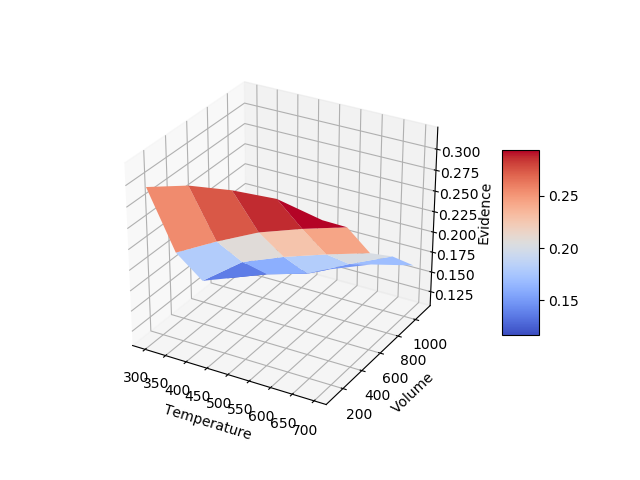

In [5]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
T, V = np.meshgrid(temperatures, volumes)
evidences=np.asarray(evidences)
E = evidences.reshape(T.shape)
surf = ax.plot_surface(T,V,E,cmap=matplotlib.cm.coolwarm)

ax.set_xlabel('Temperature')
ax.set_ylabel('Volume')
ax.set_zlabel('Evidence')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [3]:
t_bounds=(298.15,1000)
v_bounds=(100,1100)
bounds=[t_bounds,v_bounds]

ip_object = ip()

def maximize(args):
    print(args)
    path_vars.append([args[0],args[1]])
    sol = odeint(cmr, F0, np.linspace(0,args[1],100), args=(1.1*k_1,1.1*k_minus_1,1.1*k_m,args[0]))
    conc_sol_last=sol[-1,0].T
    ip_object.experiment = conc_sol_last
    ip_object.temperature = args[0]
    ip_object.volume = args[1]
    [evidence, info_gain, samples] = ip_object.MetropolisHastings()
    info_gains_path.append(info_gain)
    print(info_gain)
    return (-1)*info_gain

In [4]:
from time import time
import mystic
from mystic.solvers import diffev
from mystic.monitors import VerboseMonitor
mon = VerboseMonitor(10)
path_vars=[]
info_gains_path=[]
start_time=time()
res = diffev(maximize, x0=(450,900), bounds=bounds, maxiter=5, itermon=mon, disp=False, full_output=True, ftol=1e-3)
end_time=time()

[450.0, 900.0]
2.5716448132749594
[427.5221896559647, 924.9894447085003]
2.5553540468256513
[435.97289445837305, 906.8115704043117]
2.6641438829778537
[446.07597576056287, 862.493550806086]
2.6956156412661367
Generation 0 has ChiSquare: -2.695616
[431.23294687688434, 912.4902659280174]
2.515732830929231
[437.993510718811, 897.9479664846666]
2.602717409872179
[446.07597576056287, 862.493550806086]
2.6123714006558516
[452.54194779396437, 834.1300182632215]
2.601673546389324
[452.54194779396437, 834.1300182632215]
2.5486931591457234
[454.1584408023147, 827.0391351275053]
2.5484254545410625
[446.07597576056287, 862.493550806086]
2.556418535597851
[444.45948275221247, 862.493550806086]
2.61547361921767
[454.1584408023147, 827.0391351275053]
2.5551245446994466
[454.1584408023147, 827.0391351275053]
2.5904177509938675
[446.07597576056287, 862.493550806086]
2.6407964424475954
[437.993510718811, 897.9479664846666]
2.5395487925782363
[452.54194779396437, 834.1300182632215]
2.5645223909664265
[43

In [5]:
print(res)
print(end_time-start_time)

(array([439.61000373, 890.85708335]), -2.6956156412661367, 5, 24, 2)
930.0395510196686


In [6]:
import pickle

#Save data
with open('max_info_gain.pickle','wb') as outfile:
    pickle.dump((path_vars,info_gains_path,res),outfile)

In [11]:
import pickle
# Load data
path_vars,info_gains_path,res = pickle.load(open('max_info_gain.pickle','rb'))

<IPython.core.display.Javascript object>


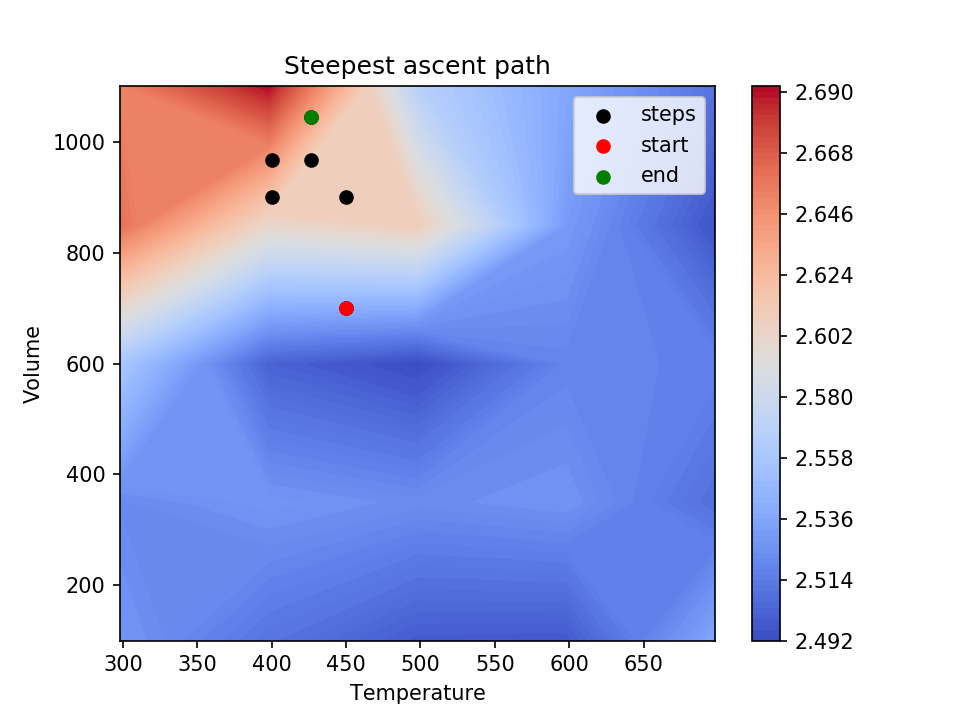

Text(0.5, 1.0, 'Steepest ascent path')

In [28]:
%matplotlib notebook
plt.contourf(T,V,IG,100,cmap=matplotlib.cm.coolwarm)
plt.colorbar()
#plt.plot(*zip(*path_vars),c='black')
plt.scatter(steep_t,steep_v,c='black',label="steps")
plt.scatter(steep_t[0],steep_v[0],c='red',label="start")
plt.scatter(steep_t[-1],steep_v[-1],c='green',label="end")
#plt.scatter(path_vars[0][0],path_vars[0][1],c='red')
#plt.scatter(path_vars[-1][0],path_vars[-1][1],c='green')
plt.legend()
plt.xlabel('Temperature')
plt.ylabel('Volume')
plt.title('Steepest ascent path')

In [9]:
ts=[var[0] for var in path_vars]
vs=[var[1] for var in path_vars]

<IPython.core.display.Javascript object>


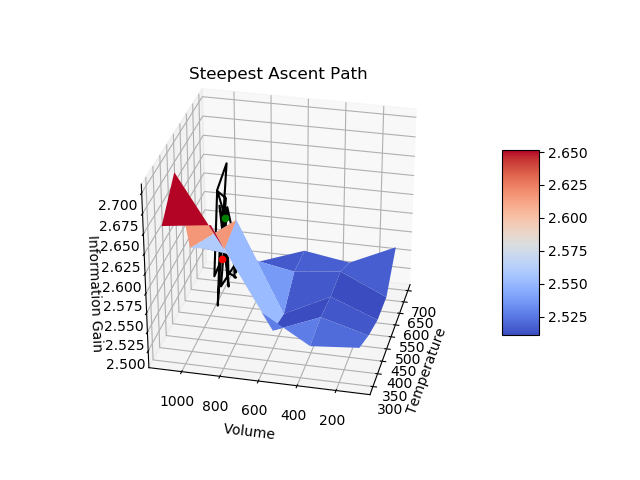

Text(0.5, 0.92, 'Steepest Ascent Path')

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.plot(ts,vs,info_gains_path,'k-')
ax.scatter(ts[0],vs[0],info_gains_path[0],c='red')
ax.scatter(ts[-1],vs[-1],info_gains_path[-1],c='green')
surf = ax.plot_surface(T,V,IG,cmap=matplotlib.cm.coolwarm)
ax.set_xlabel('Temperature')
ax.set_ylabel('Volume')
ax.set_zlabel('Information Gain')
fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.set_xticks(np.linspace(298.15,998.15,8))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.set_title('Steepest Ascent Path')

In [4]:
init_point=np.array([400,800])
new_point=np.array([600,920])
i=0
delta=0.0
ip_object = ip()
while i<10 or any(delta)<0.001:
    print('Iteration ',i+1)
    print('Init',init_point)
    print('New',new_point)
    sol = odeint(cmr, F0, np.linspace(0,init_point[1],100), args=(k_1,k_minus_1,k_m,init_point[0]))
    conc_sol_last=sol[-1,0].T
    ip_object.experiment = conc_sol_last
    ip_object.temperature = init_point[0]
    ip_object.volume = init_point[1]
    [evidence, info_gain, samples] = ip_object.MetropolisHastings()
    init_info_gain=info_gain
    print('Init info gain', init_info_gain)
    sol = odeint(cmr, F0, np.linspace(0,new_point[1],100), args=(k_1,k_minus_1,k_m,new_point[0]))
    conc_sol_last=sol[-1,0].T
    ip_object.experiment = conc_sol_last
    ip_object.temperature = new_point[0]
    ip_object.volume = new_point[1]
    [evidence, info_gain, samples] = ip_object.MetropolisHastings()
    new_info_gain=info_gain
    print('New info gain', new_info_gain)
    delta=(new_info_gain-init_info_gain)/(new_point-init_point)
    print('Delta',delta)
    init_point=new_point
    step_size=0.1
    if any(new_point+delta)<0:
        step_size=0.001
        new_point=new_point+(step_size*delta)
    else:
        new_point=new_point+(step_size*delta)
    i+=1

Iteration  1
Init [400 800]
New [600 920]
Init info gain 2.4404043907553916
New info gain 2.453284502089059
Delta [6.44005567e-05 1.07334261e-04]
Iteration  2
Init [600 920]
New [600.00000644 920.00001073]
Init info gain 2.4432785937137953
New info gain 2.4660228281088448
Delta [3531.68286995 2119.00972197]
Iteration  3
Init [600.00000644 920.00001073]
New [ 953.16829344 1131.90098293]
Init info gain 2.459952679454132
New info gain 2.4879953642414576
Delta [7.94031792e-05 1.32338632e-04]
Iteration  4
Init [ 953.16829344 1131.90098293]
New [ 953.16830138 1131.90099616]
Init info gain 2.5177944478513403
New info gain 2.44500089604855
Delta [-9167.58656121 -5500.55192098]
Iteration  5
Init [ 953.16830138 1131.90099616]
New [ 36.40964525 581.84580407]
Init info gain 2.507977059979034
New info gain 2.2544161494684594
Delta [0.00027658 0.00046097]
Iteration  6
Init [ 36.40964525 581.84580407]
New [ 36.40967291 581.84585016]
Init info gain 2.2377876576413342
New info gain 2.2539244011218065
D

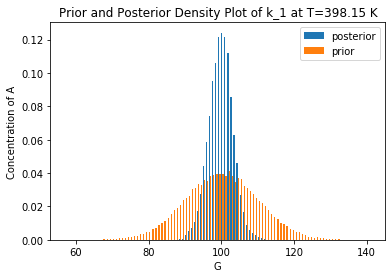

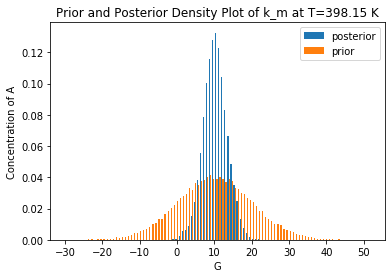

In [17]:
%matplotlib inline
mean_priors=[100,1,10]
var_priors=[10,10,10]
k_titles=['k_1','k_minus_1','k_m']
for i in range(all_samples[list(temperatures).index(398.15)*5+list(volumes).index(1100)].shape[1]):
    fig, ax = plt.subplots()
    prior = np.random.normal(mean_priors[i],var_priors[i],40000)
    (density0,bins0,pathces0)=ax.hist([all_samples[list(temperatures).index(398.15)*5+list(volumes).index(1100)][:,i],prior],bins=100,label=['posterior','prior'],density=True)
    ax.legend()
    ax.set_xlabel('G')
    ax.set_ylabel('Concentration of A')
    ax.set_title('Prior and Posterior Density Plot of '+ k_titles[i] + ' at T=398.15 K')
    fig.savefig(k_titles[i]+'.png', dpi=220)

In [21]:
# Empty dataframe
df_consolidated = pd.DataFrame()

k_1_priors=np.random.normal(1e2,10,40000)
k_minus_1_priors=np.random.normal(1,10,40000)
k_m_priors=np.random.normal(1e1,10,40000)

k_priors= np.column_stack((k_1_priors,k_minus_1_priors))
k_priors= np.column_stack((k_priors,k_m_priors))

f_a_priors=[]
temperature=398.15
# Calculating prior flow rate
for i in range(k_priors.shape[0]):
    sol = odeint(cmr, F0, np.linspace(0,1100,1000), args=(k_priors[i,0],k_priors[i,1],k_priors[i,2],temperature))
    f_a_priors.append(sol[-1,0].T)

df_consolidated=df_consolidated.append(pd.DataFrame({'Volume':1100,'Temperature':temperature,'flow_rate':f_a_priors,'F_type':'Prior'}),ignore_index=True)

# Calculating posterior flow rate
f_a_posteriors=[]
for i in range(all_samples[list(temperatures).index(398.15)*5+list(volumes).index(1100)].shape[0]):
    sol = odeint(cmr, F0, np.linspace(0,1100,1000), args=(all_samples[list(temperatures).index(398.15)*5+list(volumes).index(1100)][i,0],all_samples[list(temperatures).index(398.15)*5+list(volumes).index(1100)][i,1],all_samples[list(temperatures).index(398.15)*5+list(volumes).index(1100)][i,2],temperature))
    f_a_posteriors.append(sol[-1,0].T)

df_consolidated=df_consolidated.append(pd.DataFrame({'Volume':1100,'Temperature':temperature,'flow_rate':f_a_posteriors,'F_type':'Posterior'}),ignore_index=True)

# fig,ax = plt.subplots()
plt.figure()
ax = sns.violinplot(x='Volume',y='flow_rate',hue='F_type',data=df_consolidated,split=True)
ax.legend(loc='lower right',title='Type of Flow Rate')
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position('right')
ax.set_ylabel(r'Flow rate of A')
ax.set_xlabel(r'Volume in cm^3')
ax.set_title('Prior and Posterior flow rate of A vs Volume')
plt.savefig('F_A_violin.png', dpi=220)